# Analysis of Spatial Invariance in Convolutional Neural Networks

1.	Does data augmentation lead to more spatially invariant and robust networks?
2.	Are deep architectures more spatially invariant than wide architectures? Did a particular architecture perform better?
3.	Does generative data augmentation lead to more diverse samples than reinforcement learning techniques? Policy 2 vs. Policy 3.
4.	Do larger datasets increase spatial invariance? (Policy 2,4,5 vs. Policy 1 and 3)
5.	Do stacking data augmentation methods lead to more robust networks? Policy 5.
6.	Does combining synthesized samples with original unaugmented samples improve invariance in CNNs? Policy 4
7.	Do synthesized samples improve invariance? Policy 3
8.	Do Stochastic techniques based on Reinforcement learning techniques improve invariance? Policy 2
9.	Does the number of parameters in a CNN affect its spatial invariance as measured by its test accuracy?


# Imports

In [1]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import make_interp_spline
from pathlib import Path
import datetime
import os
import glob

# Hyperparameters

In [2]:
DATASET = "cifar10" # "cifar10", "mnist", "fmnist
NETWORK = "inception"  # "resnet", "inception"
FOLDER = "." + os.sep + DATASET + os.sep + NETWORK
HISTORY_FILE = FOLDER + os.sep + f'{DATASET}_{NETWORK}_history.csv'
METRICS_FILE = FOLDER + os.sep + f'{DATASET}_{NETWORK}_metrics.csv'
NUMBER_POLICIES = 5
NETWORK_TITLE = "ResNet-50" if NETWORK == "resnet" else "InceptionV3"
DATASET_TITLE = DATASET.upper()
NUM_EXPERIMENTS = 30

In [3]:
assert DATASET in ["cifar10", "mnist", "fmnist"], "DATASET must be cifar10, mnist or fmnist"
assert NETWORK in ["resnet", "inception"], "NETWORK must be resnet or inception"

# Load history and metrics

#### History summary

In [4]:
history = pd.read_csv(HISTORY_FILE)
print("Total records:", len(history))
history.head()

Total records: 267


,loss,accuracy,val_loss,val_accuracy,lr,policy
0,1.399057,0.539489,1.080176,0.6494,0.0001,1
1,0.478489,0.839933,0.640135,0.7898,0.0001,1
2,0.184240,0.942933,0.530684,0.8250,0.0001,1
3,0.062572,0.984156,0.570527,0.8316,0.0001,1
4,0.024526,0.994733,0.636917,0.8320,0.0001,1


#### Metrics summary

In [5]:
# Combine all metrics files into pandas dataframe
all_metric_files = Path("./").rglob('*metrics.csv')
metrics = pd.concat((pd.read_csv(f) for f in all_metric_files), ignore_index=True)
assert len(metrics) == NUM_EXPERIMENTS, "Number of experiments must be 30"
# show all metrics in the dataframe
metrics

,dataset,model,params,policy,accuracy,precision,recall,f1score,latency
0,cifar10,inception,21823274,1,0.8196,0.822895,0.819600,0.819160,1288.290989
1,cifar10,inception,21823274,2,0.9134,0.914210,0.913400,0.913495,2912.677103
2,cifar10,inception,21823274,3,0.6483,0.668018,0.648300,0.644110,1370.890961
3,cifar10,inception,21823274,4,0.8292,0.838889,0.829200,0.828989,2540.519945
4,cifar10,inception,21823274,5,0.6954,0.706803,0.695400,0.698143,1428.518826
5,cifar10,resnet,23585290,1,0.7339,0.747563,0.733900,0.735809,617.327836
6,cifar10,resnet,23585290,2,0.8517,0.853505,0.851700,0.852275,1415.693934
7,cifar10,resnet,23585290,3,0.6286,0.635144,0.628600,0.625799,587.102528
8,cifar10,resnet,23585290,4,0.7671,0.775926,0.767100,0.768330,1222.094348
9,cifar10,resnet,23585290,5,0.6915,0.700594,0.691500,0.693667,960.219147


#### Extract and plot policy histories

In [6]:
# Extract the history for each policy
policies = []
for i in range(1, NUMBER_POLICIES + 1):
    policies.append(history[history['policy'] == i])

In [7]:
def plot_history(history, policy_num):
    epochs = range(1, len(history.loss) + 1)
    # plot loss during training
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(f"Policy {policy_num} for {DATASET_TITLE} on {NETWORK_TITLE}")
    ax1.set_title("Training Loss", fontsize=10)
    ax1.plot(epochs, history.loss, "--")
    ax1.plot(epochs, history.val_loss, "--")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(["training", "validation"], loc="best")
    # plot accuracy during training
    ax2.set_title("Training Accuracy", fontsize=10)
    ax2.plot(epochs, history.accuracy, "--")
    ax2.plot(epochs, history.val_accuracy, "--")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    ax2.legend(["training", "validation"], loc="best")
    plt.tight_layout()
    plt.savefig(FOLDER + f"/{DATASET}_{NETWORK}_policy{policy_num}_plot.png")
    plt.show()
    plt.close()

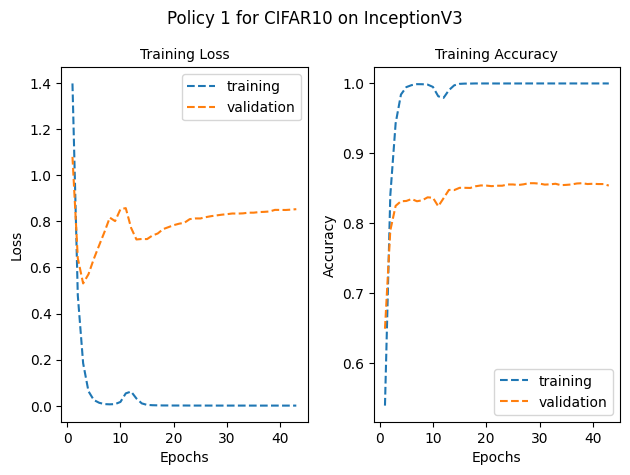

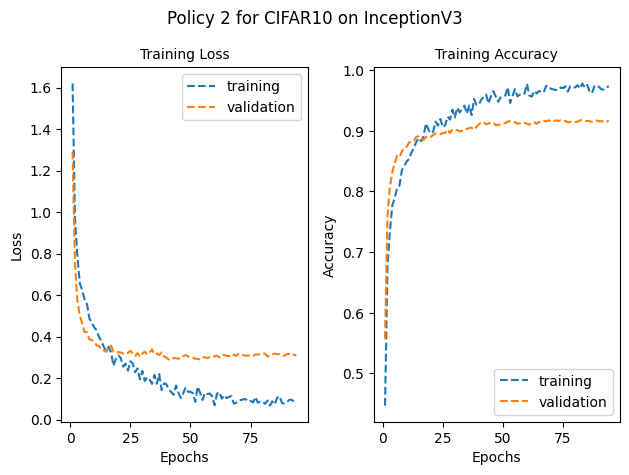

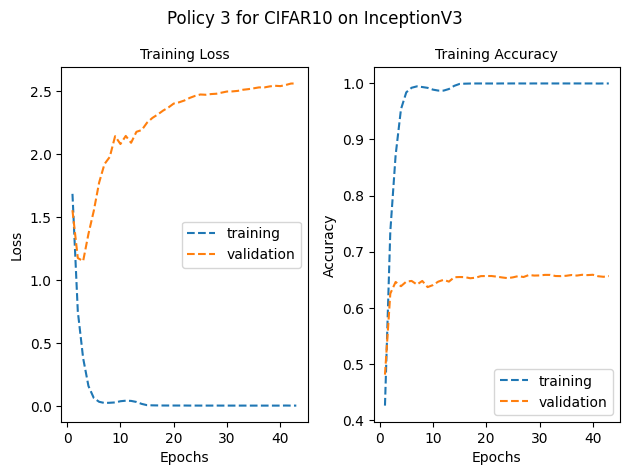

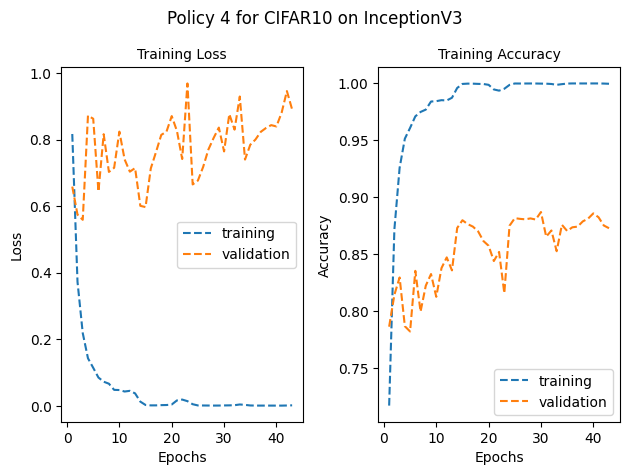

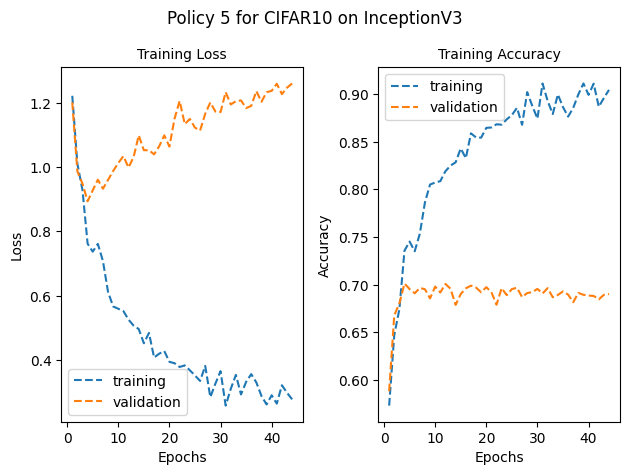

In [8]:
# Plot the history for each policy
for i, p in enumerate(policies):
    plot_history(p, i+1)

In [9]:
def plot_all_policies(policies,val=False,train=False):
    epochs = range(1, len(policies[0].loss) + 1)
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 6))
    fig.suptitle(f"All policies for {DATASET_TITLE} on {NETWORK_TITLE}")
    ax1.set_title("Training Loss", fontsize=10)
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax2.set_title("Training Accuracy", fontsize=10)
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    for i, p in enumerate(policies):
        epochs = range(1, len(p.loss) + 1)
        if train:
            ax1.plot(epochs, p.loss, "--", label=f"policy {i+1}")
            ax2.plot(epochs, p.accuracy, "--", label=f"policy {i+1}")
        elif val:
            ax1.set_title("Validation Loss", fontsize=10)
            ax2.set_title("Validation Accuracy", fontsize=10)
            ax1.plot(epochs, p.val_loss, "--", label=f"policy {i+1}")
            ax2.plot(epochs, p.val_accuracy, "--", label=f"policy {i+1}")
        else:
            ax1.set_title("Training & Validation Loss", fontsize=10)
            ax1.plot(epochs, p.loss, "--", label=f"policy {i+1} (loss)")
            ax1.plot(epochs, p.val_loss, label=f"policy {i+1} (val_loss)")
            ax2.set_title("Training & Validation Accuracy", fontsize=10)
            ax2.plot(epochs, p.accuracy, "--", label=f"policy {i+1} (acc)")
            ax2.plot(epochs, p.val_accuracy, label=f"policy {i+1} (val_acc)")
    ax1.legend(loc="best")
    ax2.legend(loc="best")
    plt.tight_layout()
    plt.savefig(FOLDER + "/{}_{}_all_policies_plot.png".format(DATASET, NETWORK))
    plt.show()
    plt.close()

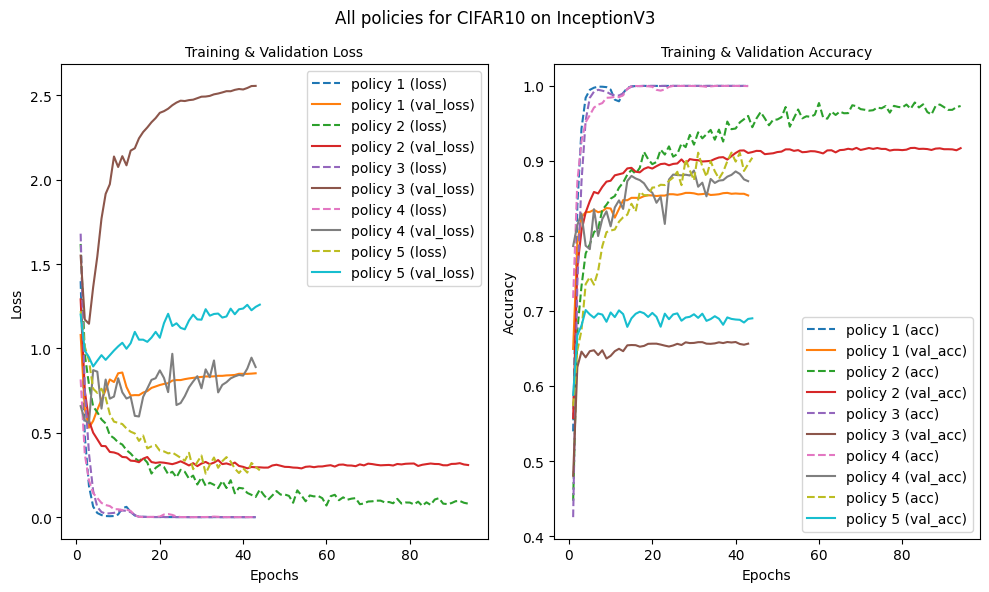

In [10]:
# plot history for all policies
plot_all_policies(policies)

#### Filter the metrics dataframe by DATASET and NETWORK

In [38]:
df = metrics.where((metrics['dataset'] == DATASET) & (metrics['model']==NETWORK)).dropna()
# cast policy column to int
df['policy'] = df['policy'].astype(int)
df

,dataset,model,params,policy,accuracy,precision,recall,f1score,latency
0,cifar10,inception,21823274.0,1,0.8196,0.822895,0.8196,0.819160,1288.290989
1,cifar10,inception,21823274.0,2,0.9134,0.914210,0.9134,0.913495,2912.677103
2,cifar10,inception,21823274.0,3,0.6483,0.668018,0.6483,0.644110,1370.890961
3,cifar10,inception,21823274.0,4,0.8292,0.838889,0.8292,0.828989,2540.519945
4,cifar10,inception,21823274.0,5,0.6954,0.706803,0.6954,0.698143,1428.518826


### Latency
#### Training latency per policy

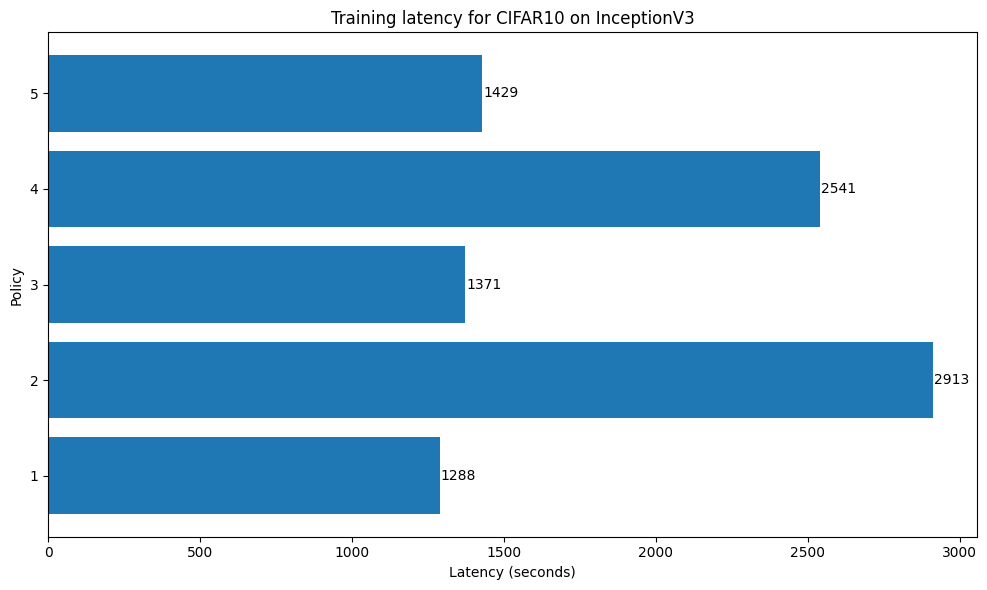

In [12]:
# plot latency for DATASET and NETWORK
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(df.policy, df.latency)
ax.bar_label(bars, fmt="%.0f", padding=1)
ax.set_title(f"Training latency for {DATASET_TITLE} on {NETWORK_TITLE}")
ax.set_xlabel("Latency (seconds)")
ax.set_ylabel("Policy")
plt.tight_layout()
plt.show()

#### Total training latency

In [13]:
train_time = metrics.pivot_table(index='model', columns='dataset', values='latency', aggfunc='sum')
# train_time.columns.name = None
# train_time.index.name = None
# ax = train_time.plot.bar(rot=0)
# ax.set_title("Total training time for all datasets and models")
# ax.set_xlabel("Model")
# ax.set_ylabel("Latency (seconds)")
# plt.tight_layout()

In [14]:
# get time delta from seconds
def get_time(num_seconds):
    h, m, s = str(datetime.timedelta(seconds=int(num_seconds))).split(':')
    #return f'{h} hours, {m} minutes and {s} seconds'
    return f'{h} hr {m} m {s} s'

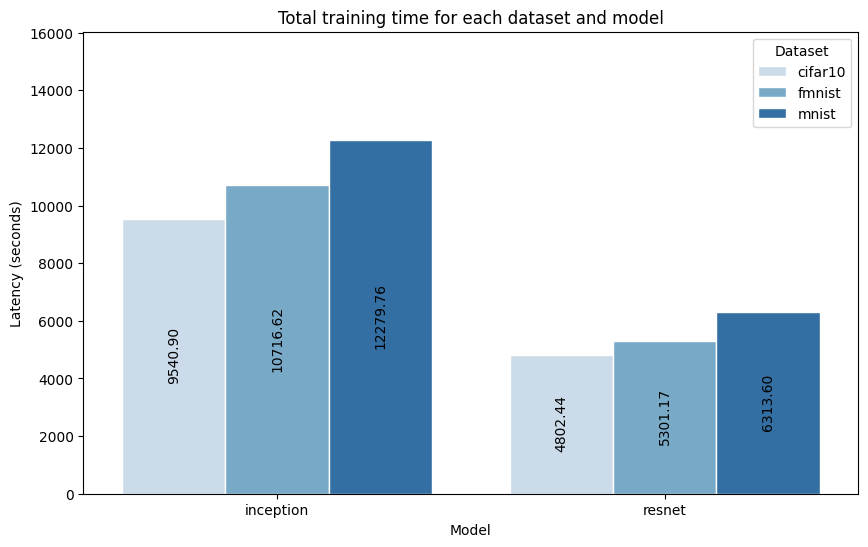

In [15]:
fig, ax = plt.subplots(figsize = (10,6))
sns.barplot(x = 'model',
            y = 'latency',
            hue = 'dataset',
            data = metrics,
            palette = "Blues",
            errwidth=0,
            estimator=sum,
            edgecolor = "w")
ax.set_title("Total training time for each dataset and model")
ax.set(xlabel='Model', ylabel='Latency (seconds)')
ax.legend(title="Dataset",loc='best')
for i in ax.containers:
    # hrs = get_time(i[0].get_height())
    # print(hrs)
    ax.bar_label(i,fmt="%.2f", padding=1,label_type='center',rotation=90)
plt.show()

In [16]:
# compute total training latency for all datasets and models
print("INCEPTION TRAINING TIME")
seconds = 0
for i in train_time.columns:
    seconds += train_time[i].inception
    time_delta = get_time(train_time[i].inception)
    print(f'{i}: {time_delta}')
print("Total train time: ", get_time(seconds))

print("\nRESNET TRAINING TIME")
seconds = 0
for i in train_time.columns:
    seconds += train_time[i].resnet
    time_delta = get_time(train_time[i].resnet)
    print(f'{i}: {time_delta}')
print("Total train time: ", get_time(seconds))

INCEPTION TRAINING TIME
cifar10: 2 hr 39 m 00 s
fmnist: 2 hr 58 m 36 s
mnist: 3 hr 24 m 39 s
Total train time:  9 hr 02 m 17 s

RESNET TRAINING TIME
cifar10: 1 hr 20 m 02 s
fmnist: 1 hr 28 m 21 s
mnist: 1 hr 45 m 13 s
Total train time:  4 hr 33 m 37 s


### Accuracy

#### Testing accuracy

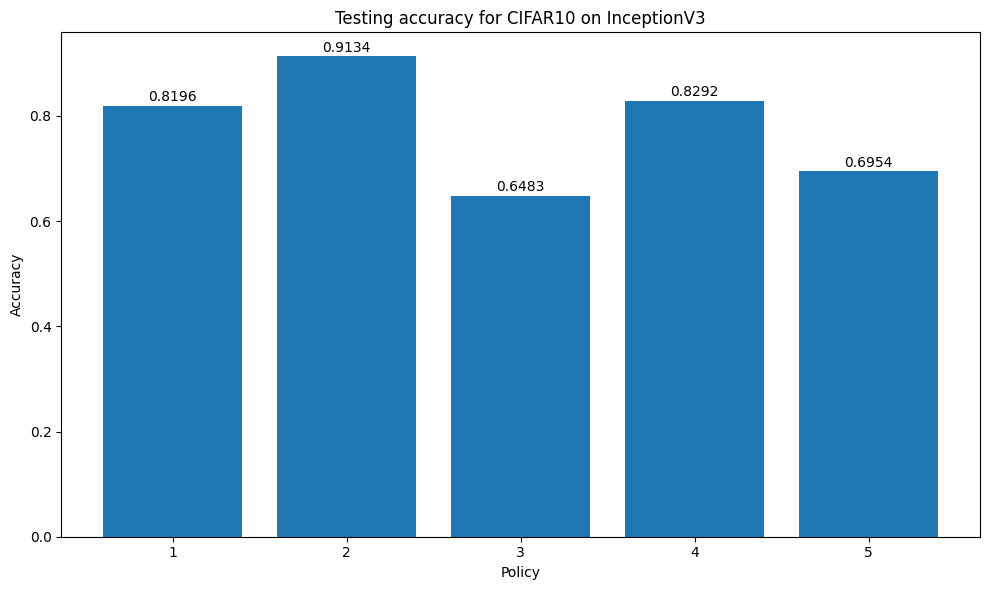

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(df.policy, df.accuracy)
ax.bar_label(bars, fmt="%.4f", padding=1)
ax.set_title(f"Testing accuracy for {DATASET_TITLE} on {NETWORK_TITLE}")
ax.set_xlabel("Policy")
ax.set_ylabel("Accuracy")
plt.tight_layout()
plt.show()

#### F-1 Score

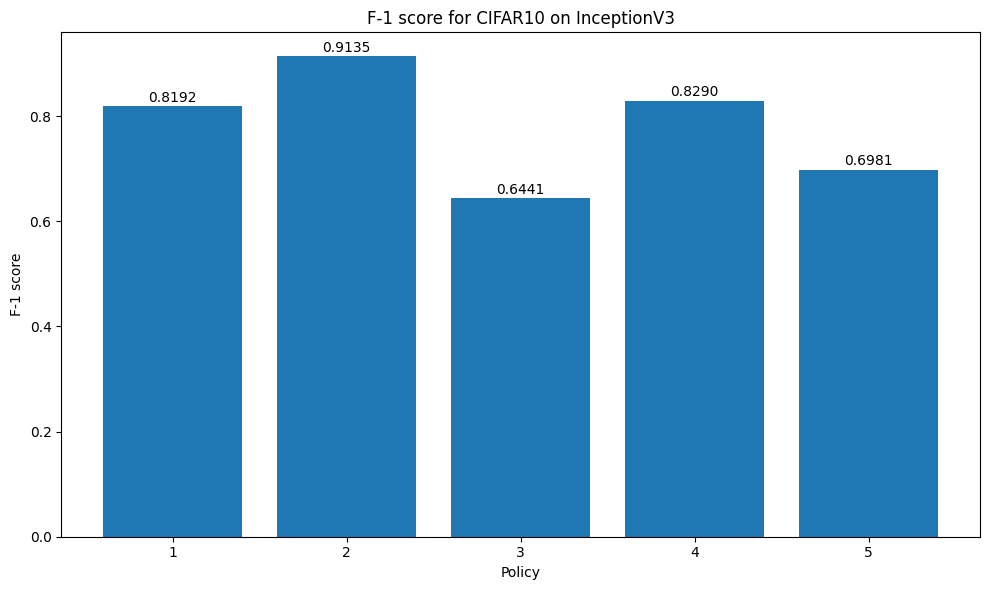

In [18]:
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(df.policy, df.f1score)
ax.bar_label(bars, fmt="%.4f", padding=1)
ax.set_title(f"F-1 score for {DATASET_TITLE} on {NETWORK_TITLE}")
ax.set_xlabel("Policy")
ax.set_ylabel("F-1 score")
plt.tight_layout()
plt.show()

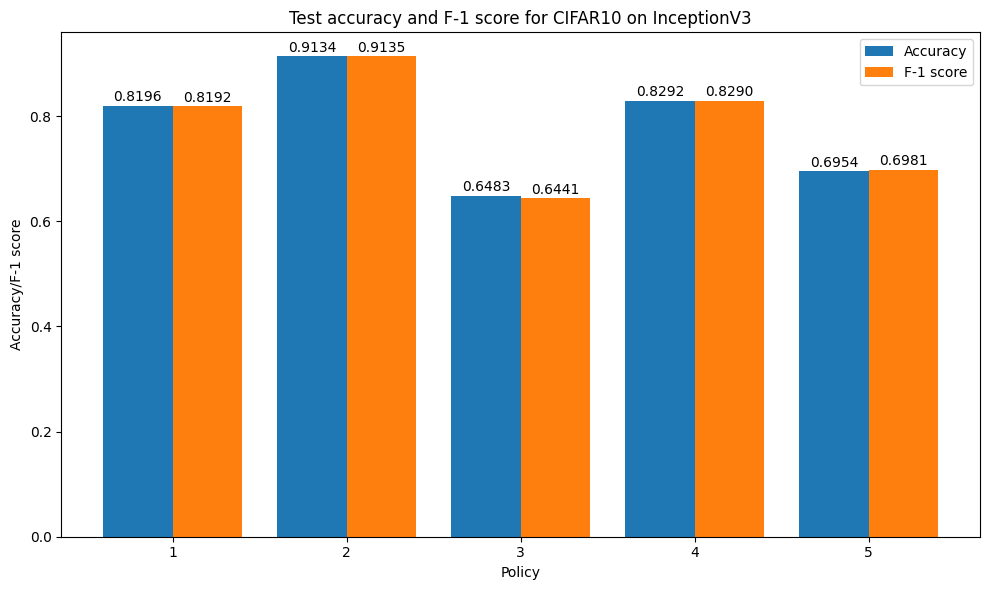

In [19]:
fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(df.policy - 0.2, df.accuracy, 0.4, label = 'Accuracy')
bar2 = ax.bar(df.policy + 0.2, df.f1score, 0.4, label = 'F-1 score')
#ax.bar_label(bar1, fmt="%.4f", padding=1,label_type='center')
ax.bar_label(bar1, fmt="%.4f", padding=1)
ax.bar_label(bar2, fmt="%.4f", padding=1)
ax.set_xlabel("Policy")
ax.set_ylabel("Accuracy/F-1 score")
ax.set_title(f"Test accuracy and F-1 score for {DATASET_TITLE} on {NETWORK_TITLE}")
ax.legend(loc='best')
plt.tight_layout()
plt.show()

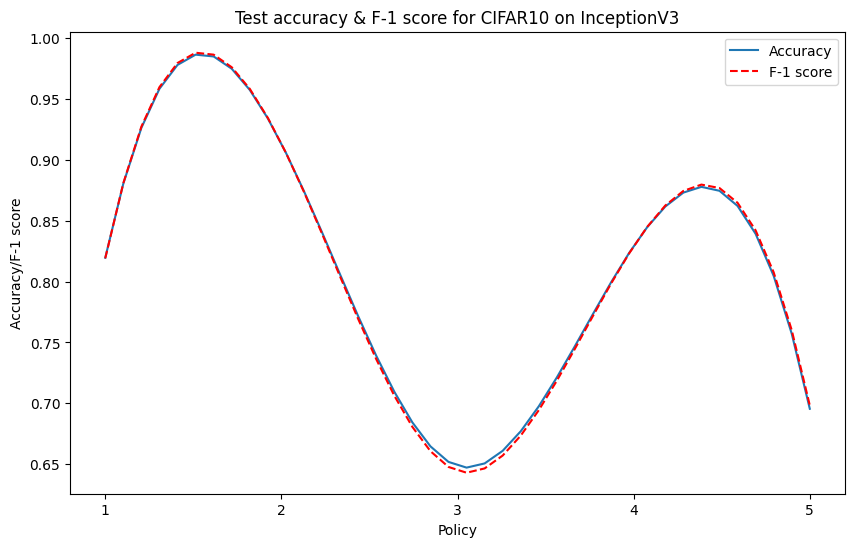

In [20]:
acc_spline = make_interp_spline(df.policy, df.accuracy)
f1_spline = make_interp_spline(df.policy, df.f1score)
X = np.linspace(df.policy.min(), df.policy.max(), 40)
Y1 = acc_spline(X)
Y2 = f1_spline(X)

fig, ax = plt.subplots(figsize=(10, 6))

# Plotting the Graph
ax.plot(X, Y1, label="Accuracy")
ax.plot(X, Y2,"r--", label="F-1 score")
ax.set_title("Test accuracy & F-1 score for {} on {}".format(DATASET_TITLE, NETWORK_TITLE))
ax.set_xlabel("Policy")
ax.set_ylabel("Accuracy/F-1 score")
ax.legend(loc="best")
ax.set_xticks(df.policy)
plt.show()


#### Percent improvement

In [37]:
df['accuracy_change'] = df.groupby('model')['accuracy'].apply(lambda x: x.div(x.iloc[0]).sub(1).mul(100)).round(2).astype(str) + '%'
df

,dataset,model,params,policy,accuracy,precision,recall,f1score,latency,pct_change,accuracy_change,%_change
0,cifar10,inception,21823274.0,1,0.8196,0.822895,0.8196,0.819160,1288.290989,0.0%,0.0%,0.0%
1,cifar10,inception,21823274.0,2,0.9134,0.914210,0.9134,0.913495,2912.677103,11.44%,11.44%,11.44%
2,cifar10,inception,21823274.0,3,0.6483,0.668018,0.6483,0.644110,1370.890961,-20.9%,-20.9%,-20.9%
3,cifar10,inception,21823274.0,4,0.8292,0.838889,0.8292,0.828989,2540.519945,1.17%,1.17%,1.17%
4,cifar10,inception,21823274.0,5,0.6954,0.706803,0.6954,0.698143,1428.518826,-15.15%,-15.15%,-15.15%


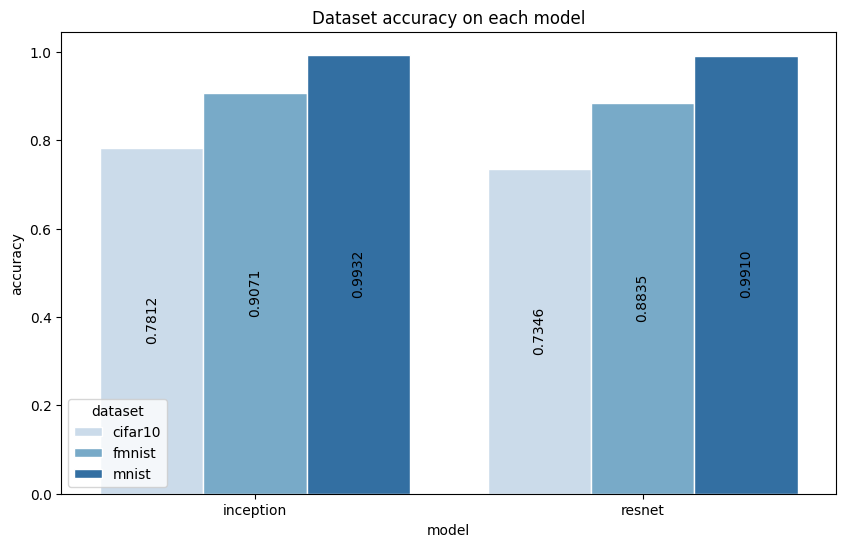

In [22]:
fig, ax = plt.subplots(figsize = (10,6))
sns.barplot(x = 'model',
            y = 'accuracy',
            hue = 'dataset',
            data = metrics,
            palette = "Blues",
            errwidth=0,
            edgecolor = "w")
ax.set_title("Dataset accuracy on each model")
for i in ax.containers:
    ax.bar_label(i,fmt="%.4f", padding=1,label_type='center',rotation=90)
plt.show()

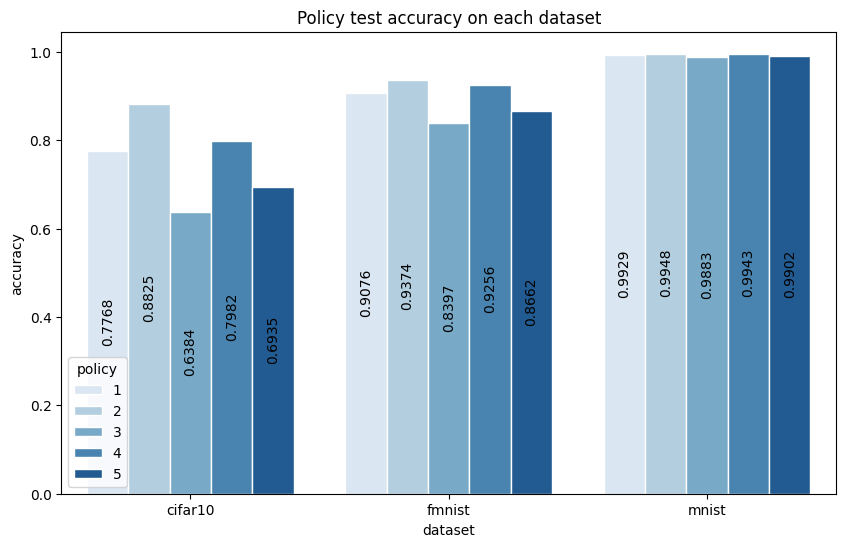

In [23]:
fig, ax = plt.subplots(figsize = (10,6))
sns.barplot(x = 'dataset',
            y = 'accuracy',
            hue = 'policy',
            data = metrics,
            palette = "Blues",
            errwidth=0,
            edgecolor = "w")
ax.set_title("Policy test accuracy on each dataset")
for i in ax.containers:
    ax.bar_label(i,fmt="%.4f", padding=1,label_type='center',rotation=90)
plt.show()

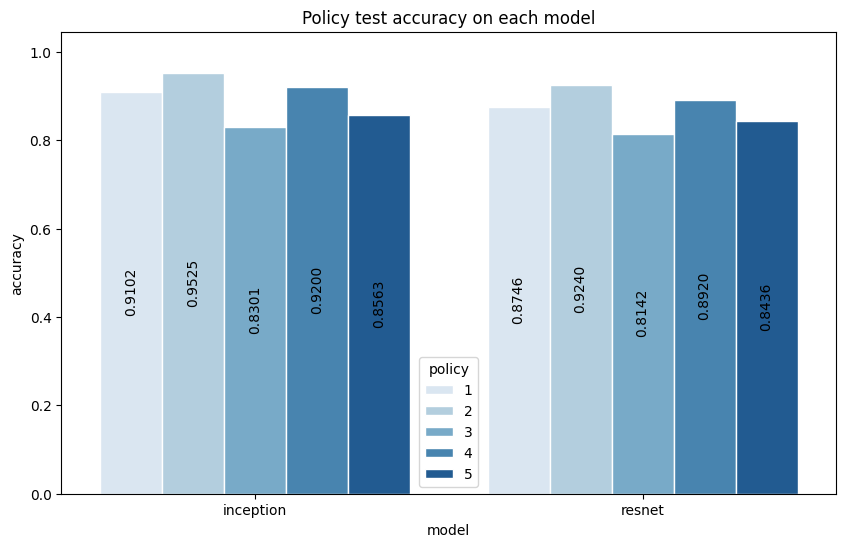

In [24]:
fig, ax = plt.subplots(figsize = (10,6))
sns.barplot(x = 'model',
            y = 'accuracy',
            hue = 'policy',
            data = metrics,
            palette = "Blues",
            errwidth=0,
            edgecolor = "w")
ax.set_title("Policy test accuracy on each model")
for i in ax.containers:
    ax.bar_label(i,fmt="%.4f", padding=1, label_type='center',rotation=90)
plt.show()

#### Accuracy based on number of parameters

In [25]:
param_stats = metrics.groupby(['model','params'])['accuracy'].describe()
param_stats = param_stats.drop(['25%','50%', '75%'],axis=1)
param_stats

,,count,mean,std,min,max
model,params,,,,,
inception,21823274,15.0,0.893820,0.108941,0.6483,0.9958
resnet,23585290,15.0,0.869693,0.119877,0.6286,0.9937


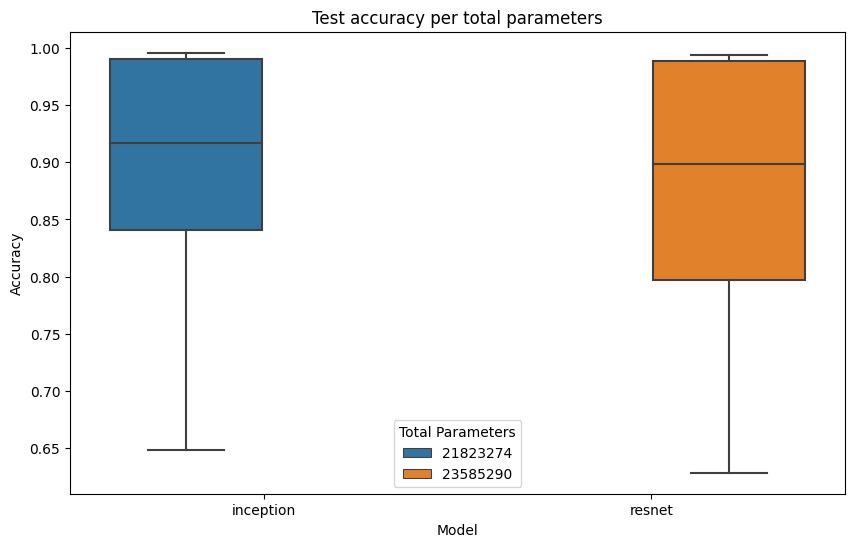

In [26]:
fig, ax = plt.subplots(figsize = (10,6))
sns.boxplot(x=metrics.model, y=metrics.accuracy, hue=metrics.params, data=metrics)
ax.set_title("Test accuracy per total parameters")
ax.set_xlabel("Model")
ax.set_ylabel("Accuracy")
ax.legend(title="Total Parameters",loc='best')
plt.show()

In [27]:
# fig, ax = plt.subplots(figsize = (10,6))
# sns.barplot(x = 'model',
#             y = 'accuracy',
#             hue = 'params',
#             data = metrics,
#             palette = "Blues",
#             errwidth=0,
#             edgecolor = "w")
# ax.set_title("Average test accuracy on each model")
# ax.legend(title="# parameters",loc='best')
# for i in ax.containers:
#     ax.bar_label(i,fmt="%.4f", padding=1)
# plt.show()